# TSM_CompVis HS 23 Homework Assignment 2

Author: Luzian Scherrer ([luzian@scherrer.ch](mailto:luzian@scherrer.ch))

GitHub: https://github.com/luzianscherrer/mlcompvis/tree/main/assignment2

**Note**

Due to copyright the dataset is not included in this repo.

## Implementation

### Configuration

In [6]:
datadir = "data"

### Imports

In [7]:
import os
import skimage
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow.keras as keras
import json
import pandas as pd

### Data Overview

test:
- 1888 test_img
- 1888 test_lbl

train:
- 23520 train_img
- 23520 train_lbl

train_small:
- 3904 train_img
- 3904 train_lbl

val:
- 8544 val_img
- 8544 val_lbl

In [8]:
with open(os.path.join(datadir, "labels.json")) as file:
    data = json.load(file)
labelid2name = {v: k for k, v in data.items()}
labelnames = list(dict(sorted(labelid2name.items())).values())

number of label images processed: 3904
highest label ID: 33
observed labels: [0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33]


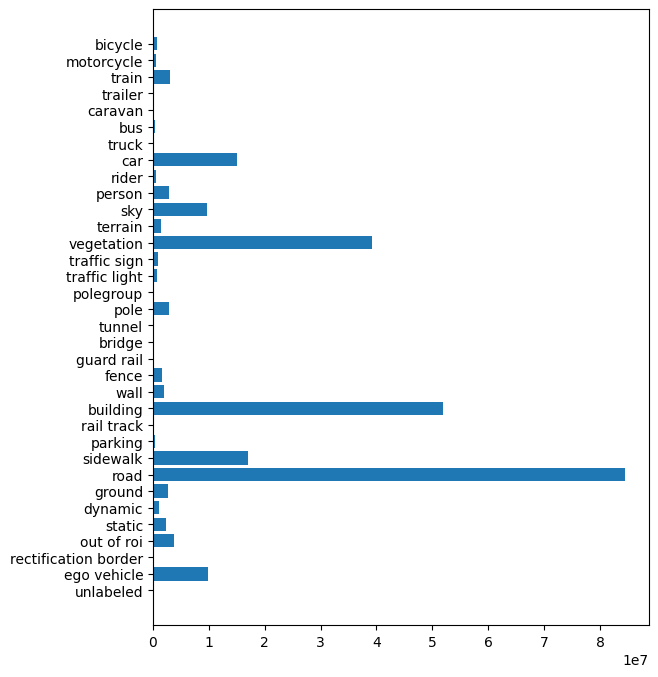

In [9]:
dir = os.path.join(datadir, "train_small")
n_labels = 0
n_total = np.zeros(256)
all_keys = []
for imgfile in os.listdir(dir):
    if imgfile.startswith("train_lbl"):
        n_labels+=1
        lbldata = skimage.io.imread(os.path.join(dir, imgfile))
        keys, values = np.unique(lbldata, return_counts=True)
        for i in range(len(keys)):
            all_keys.append(keys[i])
            n_total[keys[i]] += values[i]

print(f"number of label images processed: {n_labels}")
print(f"highest label ID: {np.max(all_keys)}")
print(f"observed labels: {sorted(np.unique(all_keys))}")

y_pos = np.arange(np.max(all_keys)+1)

fig, ax = plt.subplots()
fig.set_figheight(8)
ax.barh(y_pos, n_total[:np.max(all_keys)+1])
ax.set_yticks(y_pos, labelnames)
plt.show()

In [10]:
def imshowwithlabels(img, lbl, title=None, size=(10, 10)):

    colorlist = ('red', 'blue', 'yellow', 'magenta', 'green', 'indigo', 'darkorange', 'cyan', 'pink', 'yellowgreen')

    lblimg = skimage.color.label2rgb(lbl, img, kind='overlay', colors=colorlist)
    patches = []
    for i, id in enumerate(np.unique(lbl)):
        patches.append(mpatches.Patch(color=colorlist[i%len(colorlist)], label=labelid2name[id]))

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(size)
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[1].imshow(lblimg)
    ax[1].set_title(title)
    ax[1].axis('off')
    fig.tight_layout()
    plt.legend(handles=patches)
    plt.show()

### Show Test Image

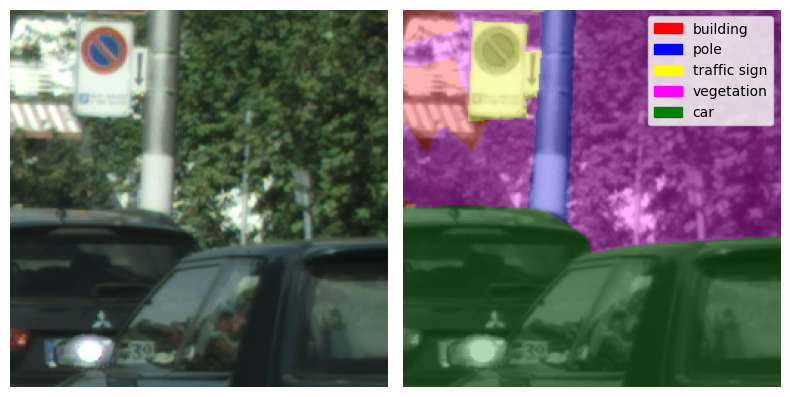

In [11]:
dir = os.path.join(datadir, "train")
lbl = skimage.io.imread(os.path.join(dir, "train_lbl_120_14.png"))
img = skimage.io.imread(os.path.join(dir, "train_img_120_14.png"))
imshowwithlabels(img, lbl, size=(8, 8))

In [12]:
def batch_generator(type, batch_size):
    dir = os.path.join(datadir, type)
    img_files = []
    lbl_files = []
    for file in os.listdir(dir):
        if file.startswith(f"{type}_img"):
            img_files.append(file)
        elif file.startswith(f"{type}_lbl"):
            lbl_files.append(file)

    while True:
        img_batch = []
        lbl_batch = []
        choice = np.random.choice(img_files, size=batch_size)
        for item in choice:
            img_file = item
            lbl_file = f"{type}_lbl" + item.replace(f"{type}_img", "")
            img_batch.append(skimage.io.imread(os.path.join(dir, img_file)) / 255.0)
            lbl_batch.append(skimage.io.imread(os.path.join(dir, lbl_file)))
        # print(f"{type} batch of size {batch_size} requested")
        yield np.array(img_batch), np.array(lbl_batch)

### Test Batch Generator

(1, 256, 256, 3)
(1, 256, 256)


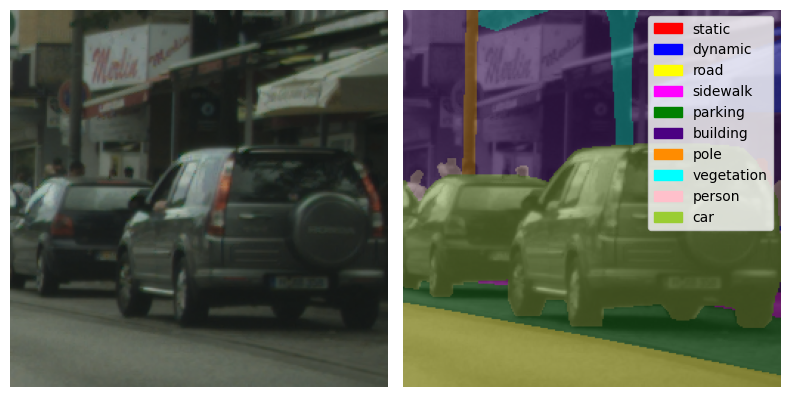

In [14]:
t_gen = batch_generator("train", 1)
for a, b in t_gen:
    print(a.shape)
    print(b.shape)
    imshowwithlabels(a[0], b[0], size=(8, 8))
    break

(1, 256, 256, 3)
(1, 256, 256)


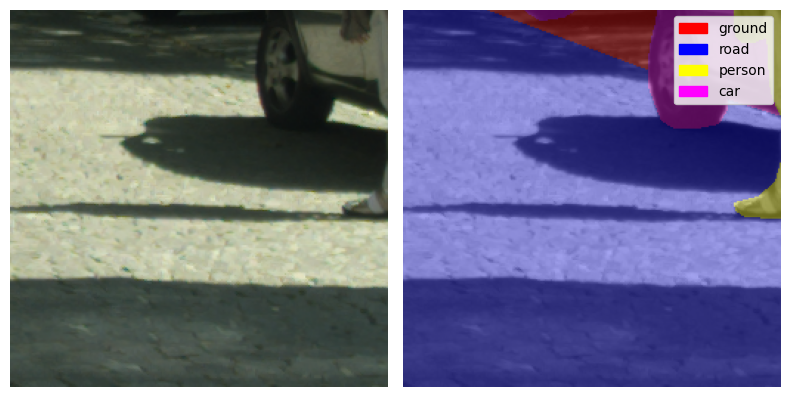

In [15]:
v_gen = batch_generator("val", 1)
for a, b in v_gen:
    print(a.shape)
    print(b.shape)
    imshowwithlabels(a[0], b[0], size=(8, 8))
    break

### Create Simple FCN

In [16]:
def simple_fcn(img_dim):
    model = keras.Sequential()

    model.add(keras.layers.Layer(input_shape=img_dim))
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=34, kernel_size=1, activation='softmax'))

    return model

**Note:** Param # for conv layers is calculated as `filters*(input_channels*(kernel_size**2)+1)`

In [17]:
model = simple_fcn((256, 256, 3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer (Layer)               (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 4)       112       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 4)       148       
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 34)      170       
                                                                 
Total params: 430 (1.68 KB)
Trainable params: 430 (1.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
100/100 [==============================] - 26s 221ms/step - loss: 3.4361 - accuracy: 0.2556 - val_loss: 3.2030 - val_accuracy: 0.1889
Epoch 2/10
100/100 [==============================] - 20s 202ms/step - loss: 2.6089 - accuracy: 0.2568 - val_loss: 2.4048 - val_accuracy: 0.3608
Epoch 3/10
100/100 [==============================] - 17s 172ms/step - loss: 2.3505 - accuracy: 0.3250 - val_loss: 2.3106 - val_accuracy: 0.3329
Epoch 4/10
100/100 [==============================] - 17s 168ms/step - loss: 2.2938 - accuracy: 0.3229 - val_loss: 2.2352 - val_accuracy: 0.3416
Epoch 5/10
100/100 [==============================] - 17s 173ms/step - loss: 2.2445 - accuracy: 0.3275 - val_loss: 2.2267 - val_accuracy: 0.3591
Epoch 6/10
100/100 [==============================] - 18s 185ms/step - loss: 2.1957 - accuracy: 0.3316 - val_loss: 2.1047 - val_accuracy: 0.3542
Epoch 7/10
100/100 [==============================] - 19s 187ms/step - loss: 2.1902 - accuracy: 0.3353 - val_loss: 2.1238 - val_ac

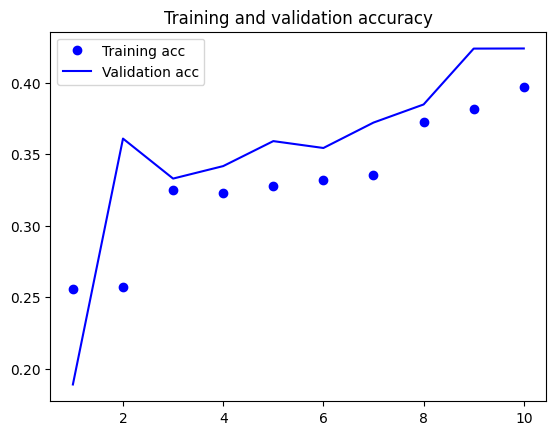

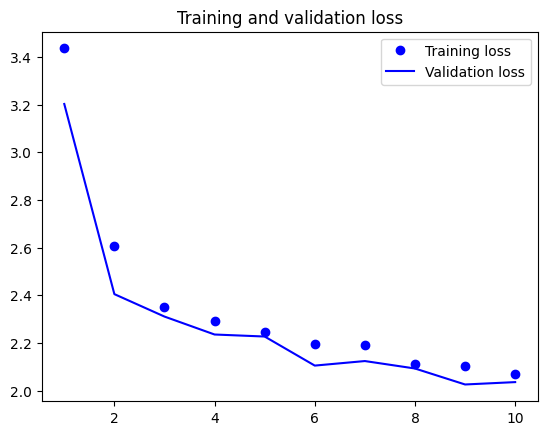

In [18]:
try:
    model = keras.models.load_model(os.path.join(datadir, "simple_fcn.keras"))
    history = np.load(os.path.join(datadir, "simple_fcn_history.npy"), allow_pickle="TRUE").item()
except:
    tensorboard = keras.callbacks.TensorBoard(
        log_dir="/tmp",
        histogram_freq=1,
        write_graph=True)

    t_gen = batch_generator("train", 20)
    v_gen = batch_generator("val", 20)

    history = model.fit(
        t_gen,
        validation_data=v_gen,
        validation_steps=20,
        epochs=10,
        steps_per_epoch=100,
        verbose=1,
        callbacks=[tensorboard]
        )

    model.save(os.path.join(datadir, "simple_fcn.keras"))
    np.save(os.path.join(datadir, "simple_fcn_history.npy"), history)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Test Simple FCN

1/1 [==============================] - 0s 272ms/step


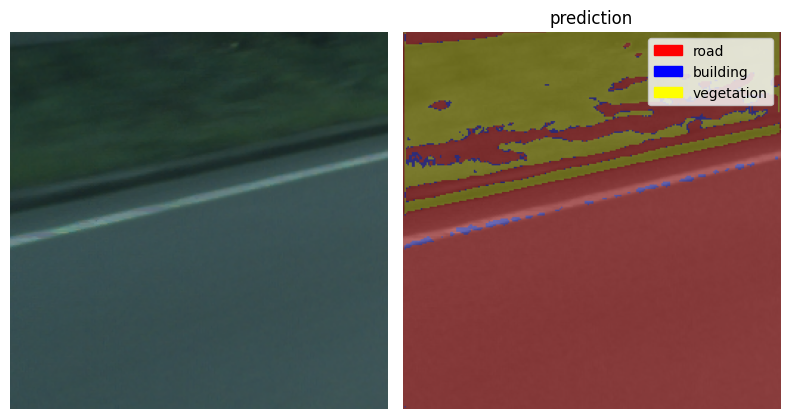

1/1 [==============================] - 0s 25ms/step


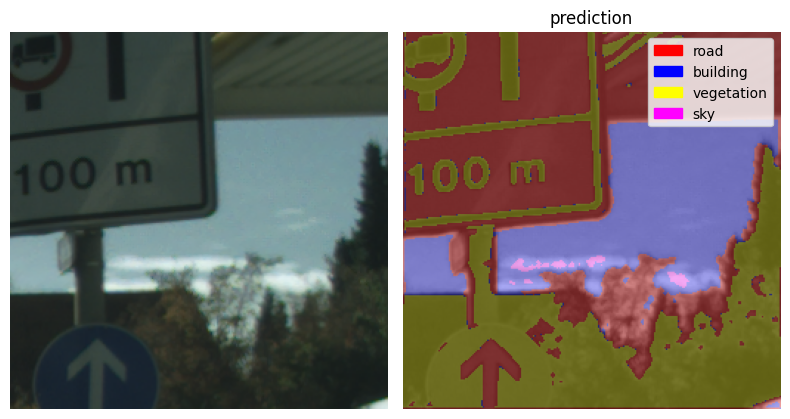

1/1 [==============================] - 0s 83ms/step


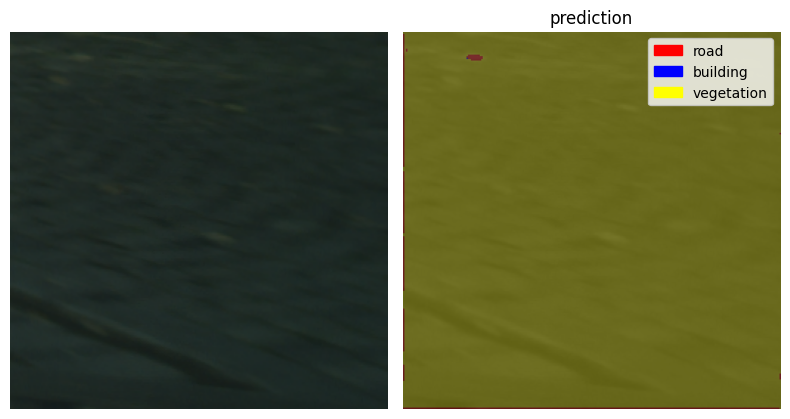

1/1 [==============================] - 0s 94ms/step


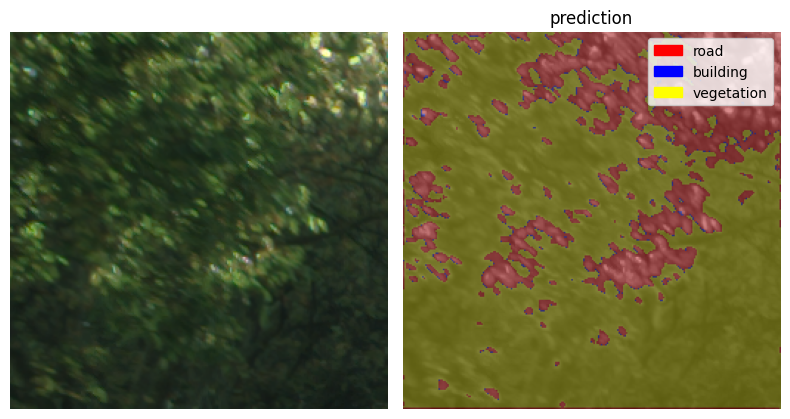

1/1 [==============================] - 0s 80ms/step


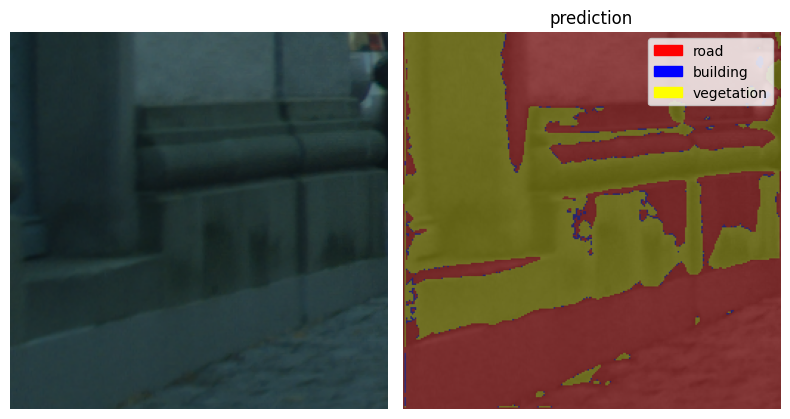

In [19]:
for _ in range(5):
    dir = os.path.join(datadir, "test")
    test_badge_no = np.random.randint(0, 59)
    test_image_no = np.random.randint(0, 32)
    imgfile = f"test_img_{test_badge_no:03d}_{test_image_no:02d}.png"
    lblfile = f"test_lbl_{test_badge_no:03d}_{test_image_no:02d}.png"
    test_img = skimage.io.imread(os.path.join(dir, imgfile))
    test_lbl = skimage.io.imread(os.path.join(dir, lblfile))
    pred_lbl = model.predict(np.array([test_img])/255.0)
    pred_lbl_flat = np.argmax(pred_lbl[0], axis=-1)
    imshowwithlabels(test_img, pred_lbl_flat, size=(8, 8), title="prediction")

### Create More Complex FCN (U_Net)

In [20]:
def convolution_operation(entered_input, filters=64):

    conv1 = keras.layers.Convolution2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = keras.layers.BatchNormalization()(conv1)
    acti1 = keras.layers.ReLU()(batch_norm1)

    conv2 = keras.layers.Convolution2D(filters, kernel_size = (3,3), padding = "same")(acti1)
    batch_norm2 = keras.layers.BatchNormalization()(conv2)
    acti2 = keras.layers.ReLU()(batch_norm2)

    return acti2


def encoder(entered_input, filters=64):

    encod1 = convolution_operation(entered_input, filters)
    MaxPool1 = keras.layers.MaxPooling2D(strides = (2,2))(encod1)

    return encod1, MaxPool1


def decoder(entered_input, skip, filters=64):
    Upsample = keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)

    Connect_Skip = keras.layers.Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)

    return out


def u_net_fcn(img_dim):
    input1 = keras.layers.Input(img_dim)

    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    conv_block = convolution_operation(encoder_4, 64*16)

    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    out = keras.layers.Convolution2D(filters=34, kernel_size=1, activation='softmax')(decoder_4)

    model = keras.models.Model(input1, out)
    return model

In [21]:
model = u_net_fcn((256, 256, 3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d_3[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 256, 256, 64)         0         ['batch_normalization[0][0

Epoch 1/32
128/128 [==============================] - 323s 2s/step - loss: 1.9974 - accuracy: 0.5134 - val_loss: 6.8162 - val_accuracy: 0.2766
Epoch 2/32
128/128 [==============================] - 243s 2s/step - loss: 1.5800 - accuracy: 0.5645 - val_loss: 3.6606 - val_accuracy: 0.3593
Epoch 3/32
128/128 [==============================] - 241s 2s/step - loss: 1.4801 - accuracy: 0.5793 - val_loss: 3.2441 - val_accuracy: 0.3070
Epoch 4/32
128/128 [==============================] - 239s 2s/step - loss: 1.3931 - accuracy: 0.6059 - val_loss: 2.9420 - val_accuracy: 0.3599
Epoch 5/32
128/128 [==============================] - 240s 2s/step - loss: 1.2989 - accuracy: 0.6269 - val_loss: 1.6052 - val_accuracy: 0.5566
Epoch 6/32
128/128 [==============================] - 241s 2s/step - loss: 1.1927 - accuracy: 0.6601 - val_loss: 2.1436 - val_accuracy: 0.4454
Epoch 7/32
128/128 [==============================] - 245s 2s/step - loss: 1.0934 - accuracy: 0.6929 - val_loss: 1.4110 - val_accuracy: 0.6372

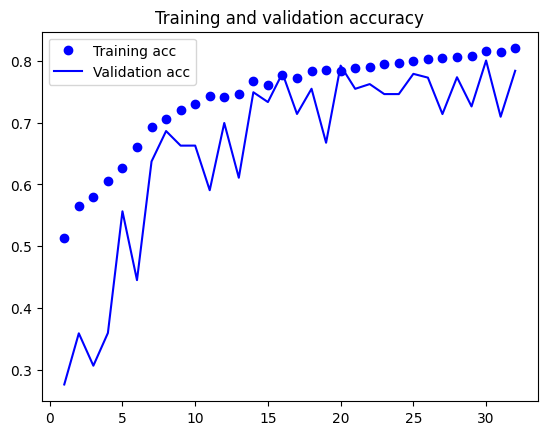

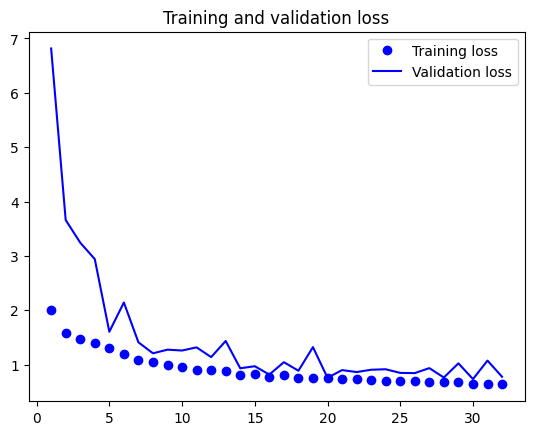

In [22]:
try:
    model = keras.models.load_model(os.path.join(datadir, "u_net_fcn.keras"))
    history = np.load(os.path.join(datadir, "u_net_fcn_history.npy"), allow_pickle="TRUE").item()
except:
    tensorboard = keras.callbacks.TensorBoard(
        log_dir="/tmp",
        histogram_freq=1,
        write_graph=True)

    t_gen = batch_generator("train", 32)
    v_gen = batch_generator("val", 32)

    history = model.fit(
        t_gen,
        validation_data=v_gen,
        validation_steps=16,
        epochs=32,
        steps_per_epoch=128,
        verbose=1,
        callbacks=[tensorboard])

    model.save(os.path.join(datadir, "u_net_fcn.keras"))
    np.save(os.path.join(datadir, "u_net_fcn_history.npy"), history)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
pd.DataFrame(history.history)

loss  accuracy  val_loss  val_accuracy
0   1.997398  0.513401  6.816243      0.276637
1   1.579957  0.564465  3.660557      0.359333
2   1.480106  0.579257  3.244062      0.306983
3   1.393109  0.605868  2.942031      0.359931
4   1.298929  0.626913  1.605214      0.556589
5   1.192715  0.660144  2.143583      0.445364
6   1.093449  0.692919  1.411022      0.637233
7   1.043565  0.705725  1.208687      0.686343
8   0.986913  0.719769  1.275780      0.662792
9   0.954639  0.729435  1.260194      0.662854
10  0.901474  0.743673  1.317800      0.590713
11  0.906469  0.741827  1.138904      0.699417
12  0.888294  0.746397  1.435346      0.610849
13  0.816895  0.766629  0.933376      0.749101
14  0.833198  0.761398  0.971215      0.733249
15  0.781827  0.776586  0.817582      0.779940
16  0.805247  0.772439  1.045309      0.713991
17  0.754569  0.783854  0.888581      0.754750
18  0.756907  0.785588  1.322475      0.667449
19  0.751394  0.784101  0.758635      0.792142
20  0.733292  0.789099  0.899886      0.754639
21  0.729406  0.790366  0.864044      0.762295
22  0.718141  0.794315  0.906445      0.746128
23  0.702697  0.796547  0.915322      0.746135
24  0.698816  0.799488  0.848546      0.778841
25  0.692338  0.802434  0.844307      0.772727
26  0.681425  0.804451  0.936423      0.713822
27  0.678447  0.805447  0.763379      0.773377
28  0.672651  0.807629  1.024175      0.726149
29  0.643043  0.816442  0.734722      0.800404
30  0.650236  0.814377  1.074753      0.709490
31  0.635396  0.819871  0.776932      0.783797

### Test U_Net

1/1 [==============================] - 0s 19ms/step


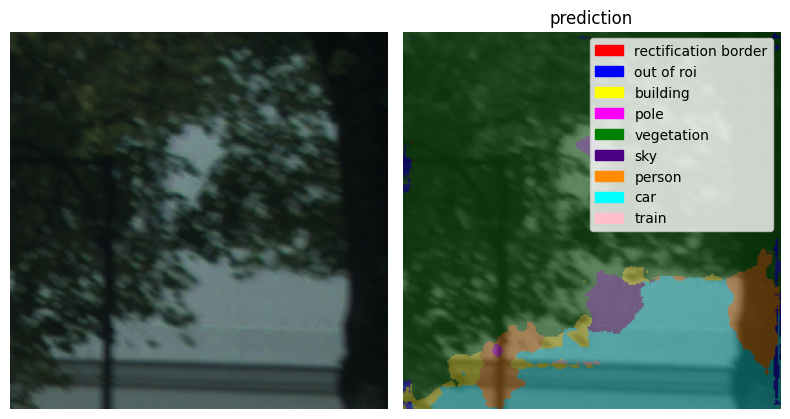

1/1 [==============================] - 0s 22ms/step


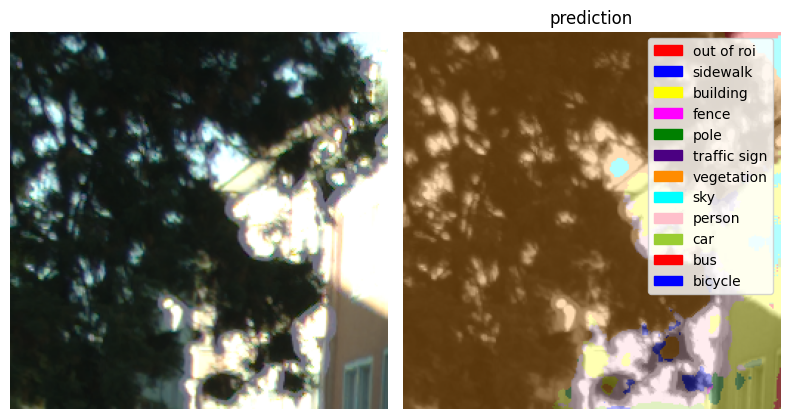

1/1 [==============================] - 0s 20ms/step


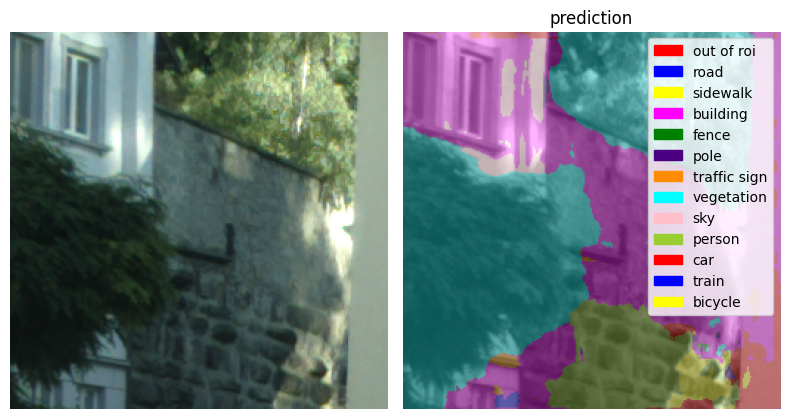

1/1 [==============================] - 0s 30ms/step


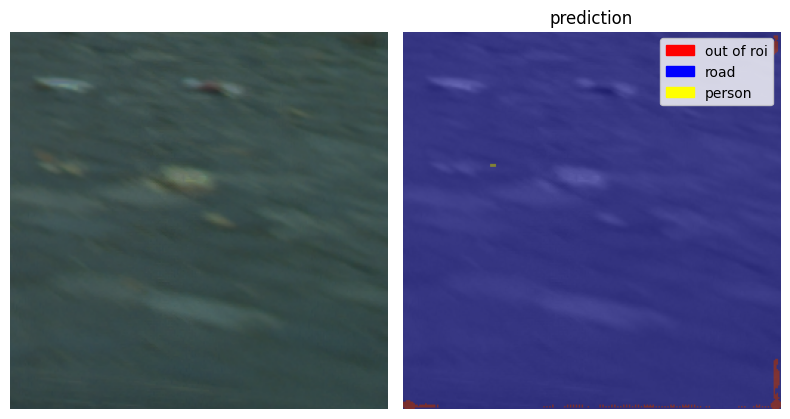

1/1 [==============================] - 0s 20ms/step


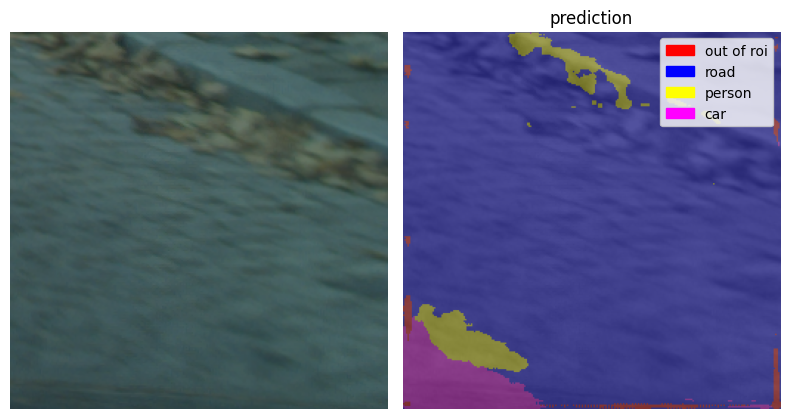

In [30]:
for _ in range(5):
    dir = os.path.join(datadir, "test")
    test_badge_no = np.random.randint(0, 59)
    test_image_no = np.random.randint(0, 32)
    imgfile = f"test_img_{test_badge_no:03d}_{test_image_no:02d}.png"
    lblfile = f"test_lbl_{test_badge_no:03d}_{test_image_no:02d}.png"
    test_img = skimage.io.imread(os.path.join(dir, imgfile))
    test_lbl = skimage.io.imread(os.path.join(dir, lblfile))
    pred_lbl = model.predict(np.array([test_img])/255.0)
    pred_lbl_flat = np.argmax(pred_lbl[0], axis=-1)
    imshowwithlabels(test_img, pred_lbl_flat, size=(8, 8), title="prediction")

In [36]:
datasets = ["train", "test", "val"]
generators = []

for dataset in datasets:
  generators.append(batch_generator(dataset, 32))

metrics = model.metrics_names

for i, dataset in enumerate(datasets):
  print(f"-- {dataset} --")
  res = model.evaluate(generators[i], steps=100)
  for i in range(len(metrics)):
    print(f"  {metrics[i]}: {res[i]}")
  print()

-- train --
100/100 [==============================] - 57s 571ms/step - loss: 0.6772 - accuracy: 0.8075
  loss: 0.6771929264068604
  accuracy: 0.8074741363525391

-- test --
100/100 [==============================] - 59s 590ms/step - loss: 1.5753 - accuracy: 0.5865
  loss: 1.5753365755081177
  accuracy: 0.5865216255187988

-- val --
100/100 [==============================] - 58s 582ms/step - loss: 0.8010 - accuracy: 0.7793
  loss: 0.801012396812439
  accuracy: 0.7793083786964417

